In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from math import pi
import numpy as np
import random
import galois

In [74]:
# right now s != 0
def get_func_details(s, num_q_inp, num_q_out, seed):
    if (num_q_inp > num_q_out):
        print("ERROR: Function can't be two-to one")

    random.seed(seed)
    # shuffle inputs
    inp_list = []
    while len(inp_list) < 2 ** num_q_inp:
        my_val = random.randint(0, 2**num_q_inp)
        if not (my_val in inp_list):
            inp_list.append(my_val)
            if (s != 0):
                inp_list.append(my_val^s)

    out_list = []
    random.seed(seed)
    if (s > 0):
        out_states = np.random.choice(
            range(2**(num_q_out)),  # numbers to sample from
            2**(num_q_inp - 1),  # number of samples
            replace=False,  # makes sure states are only sampled once
        )
    
        for i in out_states:
            out_list.append(int(i))
            out_list.append(int(i))
    else:
        out_states = np.random.choice(
            range(2**(num_q_out)),  # numbers to sample from
            2**(num_q_inp),  # number of samples
            replace=False,  # makes sure states are only sampled once
        )
        for i in out_states:
            out_list.append(int(i))

    return inp_list, out_list

In [59]:
def simon_function(s, num_q_inp, num_q_out, seed):
    inp_list,out_list = get_func_details(s, num_q_inp, num_q_out, seed)
    print("inputs to function:")
    print(inp_list)
    print("outputs to function:")
    print(out_list)

    qc = QuantumCircuit(num_q_inp + num_q_out)

    def flip_bitmask(mask):
        for i in range(num_q_inp):
            if (mask & (2 ** i)) == 0:
                qc.x(i)

    def turn_bit_on(key, turn):
        qc.barrier()
        flip_bitmask(key)
        qc.mcx(list(range(num_q_inp)), turn)
        flip_bitmask(key)

    for (inp, out) in zip(inp_list, out_list):
        qc.barrier()
        for i in range(2 ** num_q_out):
            if (out & (2 ** i)) != 0:
                turn_bit_on(inp, i + num_q_inp)

    return qc

In [75]:
get_func_details(0, 3, 3, 2)

([0, 1, 5, 2, 4, 3, 6, 8], [3, 5, 1, 6, 0, 2, 7, 4])

In [5]:
def compile_circuit(s, num_q_inp, num_q_out, seed):
    qc = QuantumCircuit(QuantumRegister(num_q_inp + num_q_out, "q"), ClassicalRegister(num_q_inp, "a"))
    
    # create first superposistion
    qc.h(range(0, num_q_inp))
    
    qc = qc.compose(simon_function(s, num_q_inp, num_q_out, seed))

    #second superposition
    qc.barrier()
    qc.h(range(0, num_q_inp))

    qc.measure(range(0, num_q_inp), range(0, num_q_inp))
    return qc

[3, 1, 8, 10, 2, 0, 5, 7]
[np.int64(5), np.int64(5), np.int64(7), np.int64(7), np.int64(6), np.int64(6), np.int64(2), np.int64(2)]


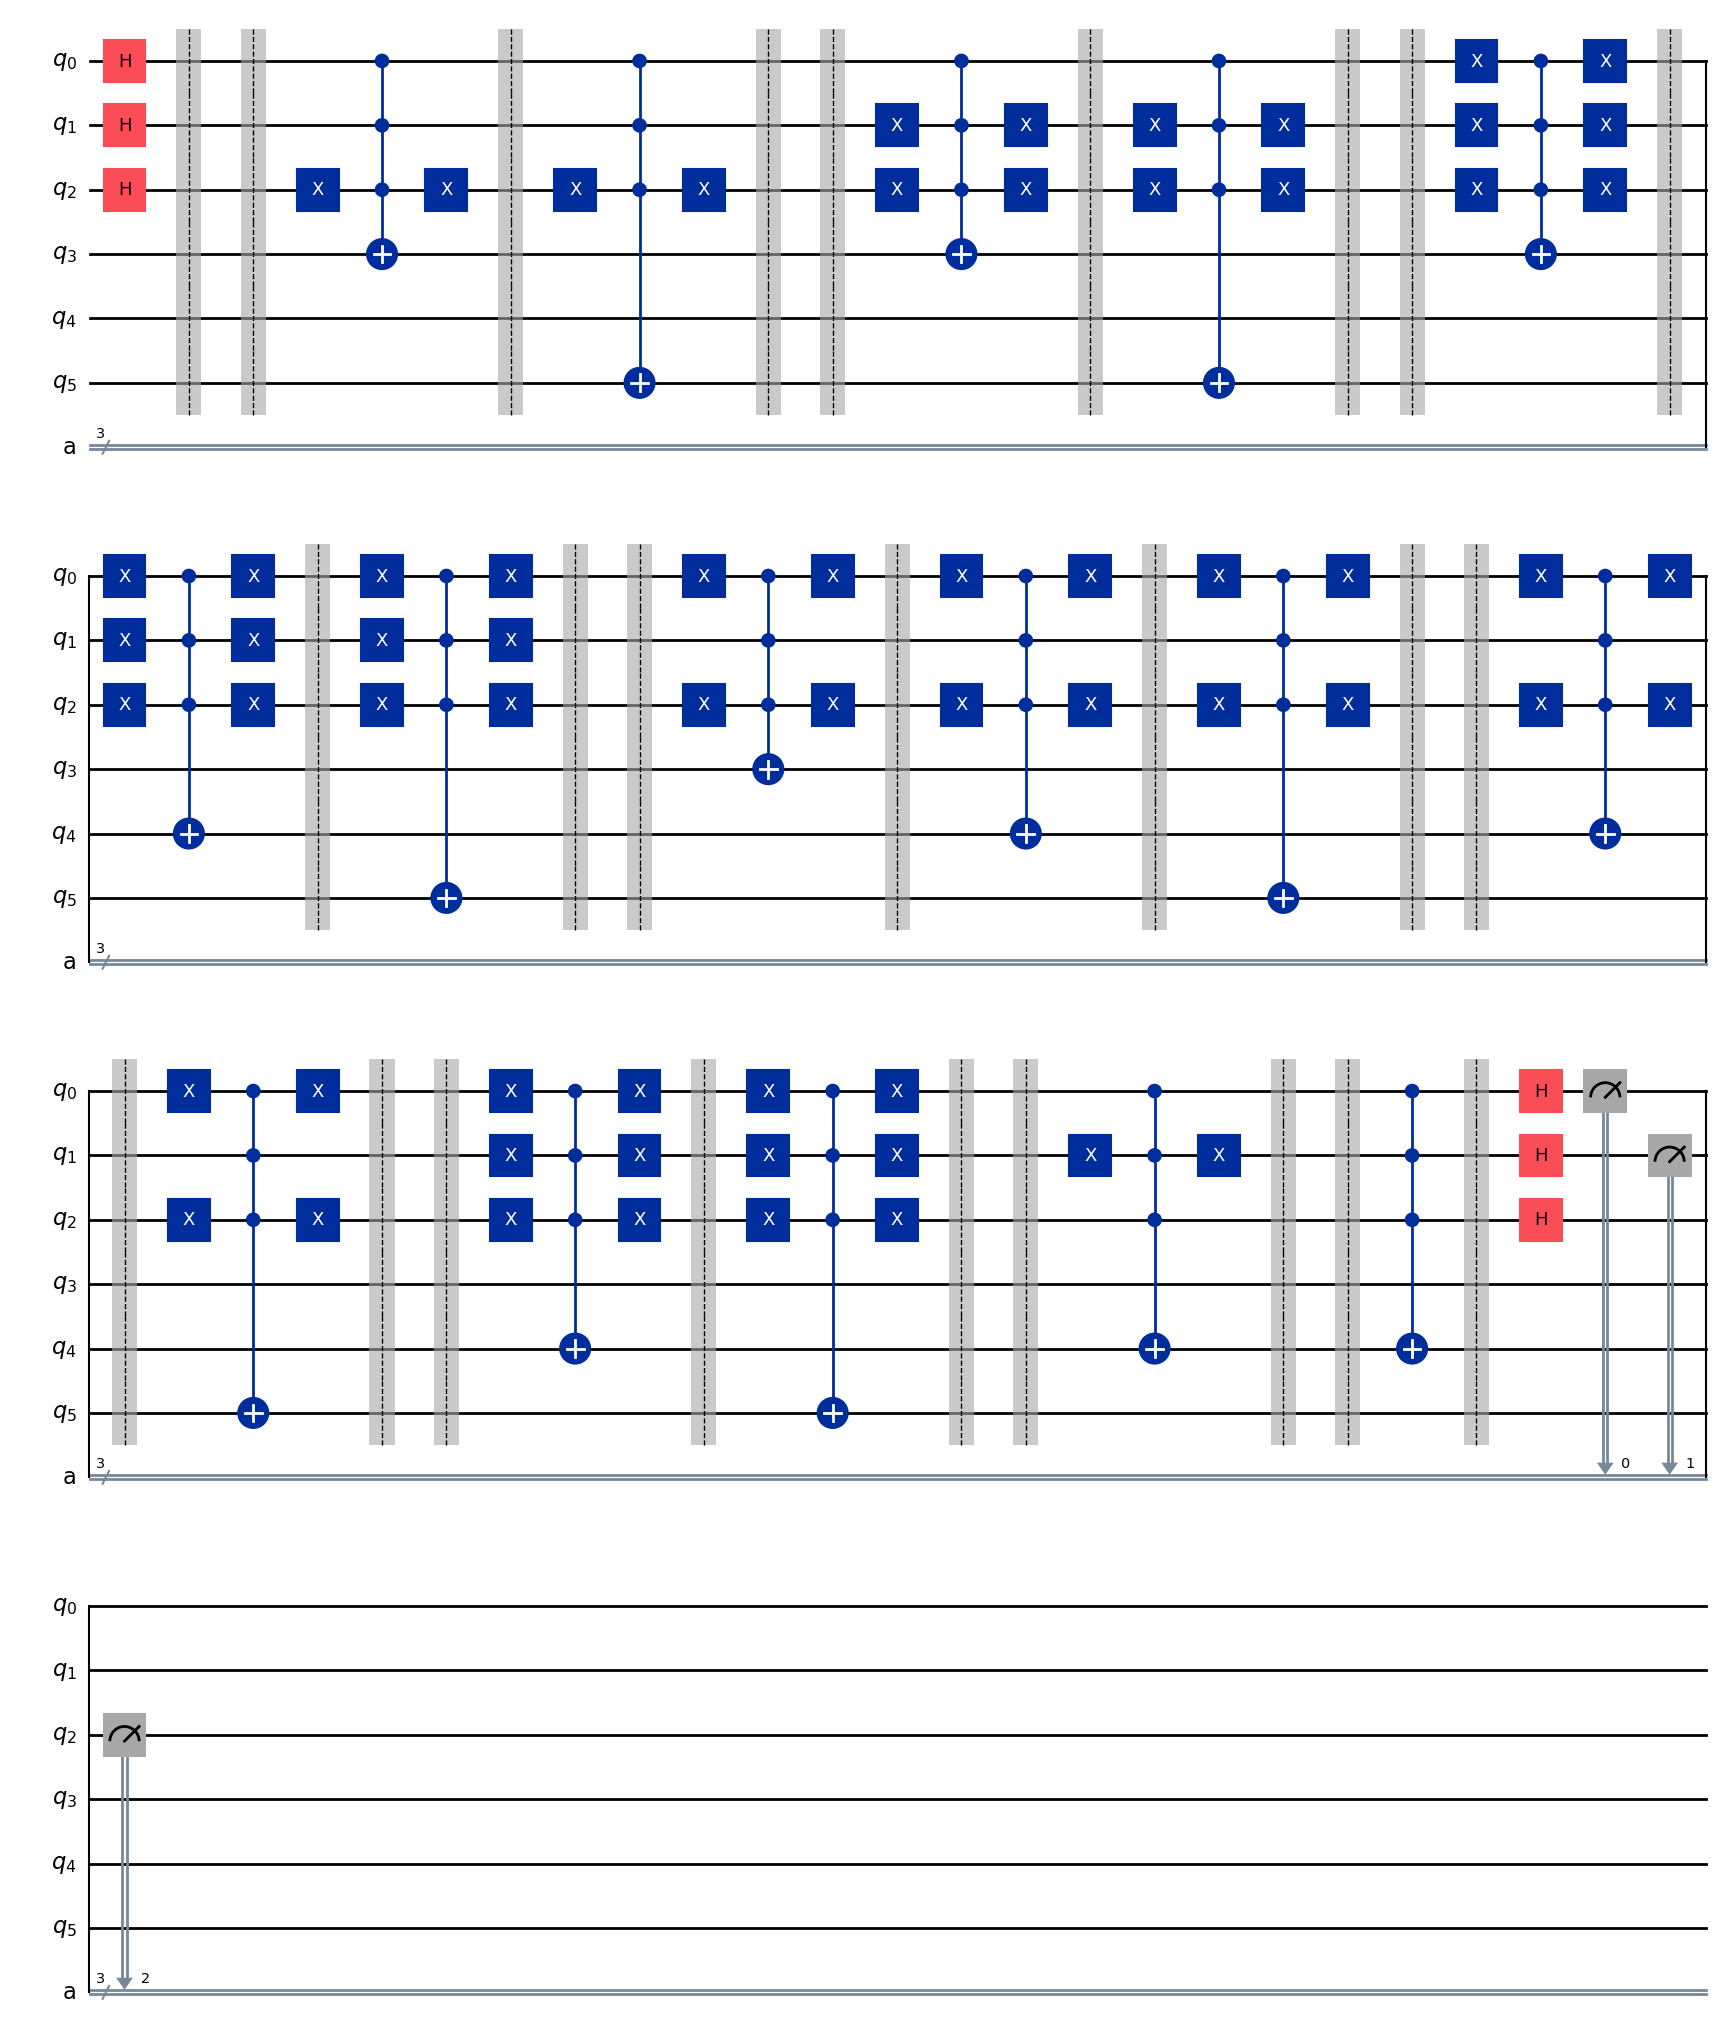

In [6]:
display(compile_circuit(2, 3, 3, 3).draw("mpl"))

In [7]:
def do_run_of_simon(s, num_q_inp, num_q_out, seed):
    result = AerSimulator().run(compile_circuit(s, num_q_inp, num_q_out, seed), shots=100).result()
    statistics = result.get_counts()

    print(statistics)

In [8]:
do_run_of_simon(1, 3, 3, 2)

[0, 1, 5, 4, 2, 3, 6, 7]
[np.int64(6), np.int64(6), np.int64(0), np.int64(0), np.int64(5), np.int64(5), np.int64(3), np.int64(3)]
{'010': 17, '000': 28, '100': 28, '110': 27}


In [77]:
r = 5
num_q_inp = 10
num_q_out = 15
num_runs = num_q_inp + r
s = 431
seed = 4
GF2 = galois.GF(2)

def get_matrix():
    result = AerSimulator().run(compile_circuit(s, num_q_inp, num_q_out, seed), shots=num_runs).result()
    statistics = result.get_counts()

    mat = []
    for num in statistics.keys():
        curr = []
        for i in num:
            if i == '0':
                curr.append(0)
            else:
                curr.append(1)
        mat.append(curr)
    return mat

In [53]:
def vec_to_int_be(v):
    x = 0
    for bit in v:              # MSB -> LSB
        x = (x << 1) | int(bit)
    return x

def recover_s():
    A = GF2(get_matrix())
    null_space_basis = A.null_space()

    if (len(null_space_basis) == 0):
        return 0
    if (len(null_space_basis) == 1):
        return vec_to_int_be(null_space_basis[0])
    print("INCONCLUSIVE")
    return -1

In [ ]:
recover_s()

inputs to function:
[483, 76, 621, 962, 211, 380, 811, 644, 980, 635, 317, 146, 184, 279, 136, 295, 40, 391, 822, 665, 592, 1023, 120, 471, 454, 105, 737, 846, 566, 921, 353, 206, 217, 374, 536, 951, 439, 24, 52, 411, 533, 954, 556, 899, 396, 35, 337, 254, 634, 981, 593, 1022, 762, 853, 177, 286, 691, 796, 794, 693, 509, 82, 364, 195, 506, 85, 969, 614, 573, 914, 182, 281, 14, 417, 597, 1018, 638, 977, 399, 32, 847, 736, 867, 716, 590, 993, 882, 733, 924, 563, 330, 229, 477, 114, 624, 991, 531, 956, 88, 503, 166, 265, 94, 497, 947, 540, 574, 913, 965, 618, 702, 785, 297, 134, 400, 63, 845, 738, 415, 48, 903, 552, 565, 922, 376, 215, 728, 887, 892, 723, 656, 831, 406, 57, 662, 825, 126, 465, 468, 123, 568, 919, 486, 73, 250, 341, 678, 777, 363, 196, 595, 1020, 940, 515, 87, 504, 731, 884, 169, 262, 585, 998, 669, 818, 37, 394, 661, 826, 591, 992, 658, 829, 313, 150, 840, 743, 159, 304, 600, 1015, 392, 39, 909, 546, 598, 1017, 512, 943, 781, 674, 325, 234, 19, 444, 744, 839, 91, 500, 931